In [1]:
import numpy as np
import pandas as pd
import nltk
import re

In [2]:
nltk.download('stopwords')
nltk.download('punkt') # one time execution

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yiwenshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yiwenshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stop_words = stopwords.words('english')

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-06-08 13:35:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-08 13:35:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-08 13:35:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()
len(word_embeddings)

400000

In [7]:
df = pd.read_csv('project_hub.csv')

In [8]:
df.head()

,catigory,link,text,Text_Rank,LEAD3,BART,text_len,LEAD3_len,LEAD3_len_percent,Text_Rank_len,Text_Rank_len_percent,BART_len,BART_len_percent
0,audio-sound,https://create.arduino.cc//projecthub/buzzandy...,My niece is getting into music so I to make he...,Introduction This project was pretty simple an...,My niece is getting into music so I to make he...,My niece is getting into music so I to make h...,262.0,37.0,0.141221,85.0,0.324427,63.0,0.240458
1,audio-sound,https://create.arduino.cc//projecthub/shajeeb/...,This project is for making a band audio music ...,Main of this frequency spectrum analyzer easil...,This project is for making a band audio music ...,This project is for making a band audio music...,810.0,47.0,0.058025,157.0,0.193827,61.0,0.075309
2,audio-sound,https://create.arduino.cc//projecthub/ericBcre...,The idea seen some I thought it would be cool ...,fooling around with a spinning and version exc...,The idea seen some I thought it would be cool ...,The idea seen some I thought it would be cool...,590.0,60.0,0.101695,192.0,0.325424,51.0,0.086441
3,audio-sound,https://create.arduino.cc//projecthub/lindsi87...,To begin I should fill you in that I am comple...,and setting the frequency for each of the pian...,To begin I should fill you in that I am comple...,The basic for both the main and the individua...,789.0,64.0,0.081115,90.0,0.114068,45.0,0.057034
4,audio-sound,https://create.arduino.cc//projecthub/jrance/s...,Learning electronics not only can be fan but i...,I used to be one of those thinking I would nev...,Learning electronics not only can be fan but i...,Learning electronics not only can be fan but ...,219.0,62.0,0.283105,86.0,0.392694,68.0,0.310502


In [9]:
df['text'][0]

'My niece is getting into music so I to make her something cool for her room . I also been interested in sound reactive so this was a good learning project . Here s the on . Introduction This project was pretty simple and been done countless times but for me it was fun to put together a bunch of and to package it into a fun end product I used the as the base . Used the library to decode the sound into library to drive the led and an old C case to hold it all together . A few about the I use a POT to control the sound sensitivity Microphone amplifier is sensitive to noise so I shielded the with grounded metal tape which a lot . The strip in a few ways . color brightness saturation based on volume of each octave the same LED pattern across the strip but the colors and flip each set so it more continuous as it the pattern along the strip at the it white briefly you need to test out the pink noise to get it tuned correctly . this from board to board I used an old . Wall Wart as power suppl

In [10]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [11]:
TOP = 3
for idx, row in df.iterrows():
    sentences = sent_tokenize(row['text'])
    
    # remove punctuations, numbers and special characters
    clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ", regex=True)

    # make alphabets lowercase
    clean_sentences = [s.lower() for s in clean_sentences]
    
    # remove stopwords from the sentences
    clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
    
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((100,))
        sentence_vectors.append(v)
    
    # similarity matrix
    matrix_size = min(100, len(sentences))
    sim_mat = np.zeros([matrix_size, matrix_size])
    for i in range(matrix_size):
        for j in range(matrix_size):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
    
    nx_graph = nx.from_numpy_array(sim_mat)
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i], sentences[i]) for i in range(matrix_size)), reverse=True)
        summary = [s[1] for s in ranked_sentences]
    except:
        print(matrix_size, idx)
        summary = sentences

    df.loc[idx, 'Text_Rank'] = ' '.join(summary[:TOP])

49 126
61 323
38 580
83 800


In [12]:
TOP = 3
for idx, row in df.iterrows():
    sentences = sent_tokenize(row['text'])
    
    # remove punctuations, numbers and special characters
    clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ", regex=True)

    # make alphabets lowercase
    clean_sentences = [s.lower() for s in clean_sentences]
    
    df.loc[idx, 'LEAD3']= ' '.join(sentences[:3])

In [12]:
!pip install transformers
from transformers import pipeline
summarizer = pipeline('summarization')

In [ ]:
for idx, row in df.iterrows():
    summary = summarizer(row['text'][:1024], max_length=200, min_length=30)
    df.loc[idx, 'BART'] = summary[0]['summary_text']

In [14]:
vocabulary_oraginal = set()
vocabulary_text_rank = set()
vocabulary_lead3 = set()
vocabulary_bart = set()

In [15]:
for idx, row in df.iterrows():
    df.loc[idx, 'text_len'] = len(word_tokenize(row['text']))
    vocabulary_oraginal.update(word_tokenize(row['text']))
    df.loc[idx, 'LEAD3_len']= len(word_tokenize(row['LEAD3']))
    df.loc[idx, 'LEAD3_len_percent']= len(word_tokenize(row['LEAD3']))/len(word_tokenize(row['text']))
    vocabulary_lead3.update(word_tokenize(row['LEAD3']))
    df.loc[idx, 'Text_Rank_len'] = len(word_tokenize(row['Text_Rank']))
    df.loc[idx, 'Text_Rank_len_percent']= len(word_tokenize(row['Text_Rank']))/len(word_tokenize(row['text']))
    vocabulary_text_rank.update(word_tokenize(row['Text_Rank']))
    df.loc[idx, 'BART_len']= len(word_tokenize(row['BART']))
    df.loc[idx, 'BART_len_percent']= len(word_tokenize(row['BART']))/len(word_tokenize(row['text']))
    vocabulary_bart.update(word_tokenize(row['BART']))

In [16]:
len(vocabulary_oraginal), len(vocabulary_lead3), len(vocabulary_text_rank), len(vocabulary_bart)

(14154, 4896, 6033, 4696)

In [19]:
df.to_csv('project_hub_summary.csv', index=False)

In [20]:
dist = df[['text_len', 'LEAD3_len', 'Text_Rank_len', 'BART_len']]
dist = dist.rename(columns={"text_len": "Original Document", "LEAD3_len": "LEAD-3", "Text_Rank_len": "Text Rank", "BART_len": "BART"}, errors="raise")

In [21]:
dist.head()

,Original Document,LEAD-3,Text Rank,BART
0,262.0,37.0,85.0,63.0
1,810.0,47.0,157.0,61.0
2,590.0,60.0,192.0,51.0
3,789.0,64.0,90.0,45.0
4,219.0,62.0,86.0,68.0


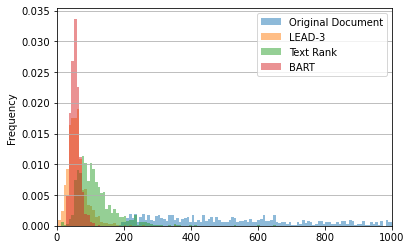

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
dist.plot.hist(density=True, ax=ax, bins=2000, alpha=0.5)
ax.grid(axis='y')
plt.xlim(0, 1000)
plt.savefig('token_length.png')

In [23]:
dist["Original Document"].describe(), dist["LEAD-3"].describe(), dist["Text Rank"].describe(), dist["BART"].describe()

(count      915.000000
 mean       951.228415
 std       1044.765386
 min        186.000000
 25%        388.500000
 50%        642.000000
 75%       1217.500000
 max      15651.000000
 Name: Original Document, dtype: float64,
 count    915.000000
 mean      60.060109
 std       29.951597
 min        4.000000
 25%       42.000000
 50%       55.000000
 75%       71.000000
 max      351.000000
 Name: LEAD-3, dtype: float64,
 count    915.000000
 mean     115.531148
 std       61.311308
 min       14.000000
 25%       77.000000
 50%      102.000000
 75%      136.000000
 max      653.000000
 Name: Text Rank, dtype: float64,
 count    915.000000
 mean      55.260109
 std       13.474106
 min       29.000000
 25%       46.000000
 50%       54.000000
 75%       63.000000
 max      129.000000
 Name: BART, dtype: float64)

In [24]:
df["LEAD3_len_percent"].mean(), df["Text_Rank_len_percent"].mean(), df["BART_len_percent"].mean()

(0.10657770997148783, 0.19036870493808547, 0.10008449658955601)